In [1]:
import sys
sys.path.append('..')
import helper
import torch
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = helper.Loader.load_data_time_machine(batch_size, num_steps)
len(vocab)

28

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [4]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [5]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [6]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [7]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = torch.nn.functional.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [8]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, helper.GPU.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], helper.GPU.try_gpu())
Y, new_state = net(X.to(helper.GPU.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [9]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [10]:
predict_ch8('time traveller ', 10, net, vocab, helper.GPU.try_gpu())

'time traveller h h h h h '

In [11]:
# 梯度裁剪
def grad_clipping(net, theta):
    if isinstance(net, torch.nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [12]:
import math
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, helper.Timer()
    metric = helper.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size  = X.shape[0], device=device)
        else:
            if isinstance(net, torch.nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size = 1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [13]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter = False):
    loss = torch.nn.CrossEntropyLoss()
    animator = helper.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, torch.nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: helper.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

time traveller the the the the the the the the the the the the t
time travellere the the the the the the the the the the the the 
time traveller the the the the the the the the the the the the t
time traveller and the the the the the the the the the the the t
time travellere the the the the the the the the the the the the 
time traveller and the the this the this the thime that in the t
time travellere the the the the the the the the the the the the 
time traveller and he pare the thice and he paree thave the thic
time traveller and and the the the the the the the the the the t
time traveller and and and and and and and and and and and and a
time traveller at and he pare he the the the the the the the the
time traveller and the the the the the the the the the the the t
time traveller andeas at he the that hes in that hes in that hes
time traveller and the perely the ond and the and the medical ma
time traveller and the this that ie sime time time time time tim
time traveller of the rea

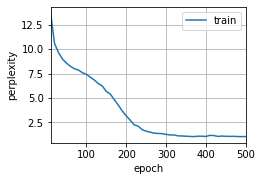

In [14]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, helper.GPU.try_gpu())